In [2]:
import scipy.io as spio
import numpy as np

In [3]:
BahramFace = spio.loadmat(file_name='../data/bci-project-data-RAW/BahramFace.mat')
DJFace = spio.loadmat(file_name='../data/bci-project-data-RAW/DJFace.mat')
NickFace = spio.loadmat(file_name='../data/bci-project-data-RAW/NickFace.mat')
RoohiFace = spio.loadmat(file_name='../data/bci-project-data-RAW/RoohiFace.mat')
SarahFace = spio.loadmat(file_name='../data/bci-project-data-RAW/SarahFace.mat')

In [4]:
FacesData = np.vstack(tup=(BahramFace['Intensification_Data'], 
                       DJFace['Intensification_Data'], 
                       NickFace['Intensification_Data'],
                      RoohiFace['Intensification_Data'],
                      SarahFace['Intensification_Data']))

In [5]:
FacesLabel = np.vstack(tup=(BahramFace['Intensification_Label'], 
                       DJFace['Intensification_Label'], 
                       NickFace['Intensification_Label'],
                      RoohiFace['Intensification_Label'],
                      SarahFace['Intensification_Label']))

In [6]:
(FacesData.shape, FacesData.dtype, FacesLabel.shape, FacesLabel.dtype)

((18720, 205, 16), dtype('<f8'), (18720, 1), dtype('uint8'))

In [7]:
# Normalizing input data
def normalize(inputs):
    return (inputs - inputs.mean(axis=0)[None,:,:]) / inputs.std(axis=0)[None,:,:]

# onehot vectorizing output labels
def one_hot(labels, n_class):
    """ One-hot encoding """
    expansion = np.eye(n_class)
    y = expansion[:, labels-1].T
    assert y.shape[1] == n_class, "Wrong number of labels!"

    return y

# get minibatches for learning
def get_batches(X, y, batch_size):
    """ Return a generator for batches """
    n_batches = len(X) // batch_size
    X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

    # Loop over batches and yield
    for b in range(0, len(X), batch_size):
        yield X[b:b+batch_size], y[b:b+batch_size]

In [8]:
# Standardize/normalize train and test
X_norm = normalize(inputs=FacesData)

In [9]:
# Deviding the input data into train and validation
# 30 % of data is test and the rest train
length = int(X_norm.shape[0] * 0.3)
X_train_norm = X_norm[: -length]
X_valid_norm = X_norm[-length:]

In [17]:
Y_train = np.array(FacesLabel[ :-length], dtype=int).reshape(-1)
Y_valid = np.array(FacesLabel[-length: ], dtype=int).reshape(-1)

In [18]:
(X_train_norm.shape, X_train_norm.dtype, Y_train.shape, Y_train.dtype)

((13104, 205, 16), dtype('<f8'), (13104,), dtype('int64'))

### Hyperparameters

In [19]:
# Input data
# X_(5832, 192, 64): (n_trials, seq_len, n_channels), batch_size== n_trials
batch_size = X_train_norm.shape[0]// 100 # Batch size: number of trials
seq_len = X_train_norm.shape[1]          # Number of steps: each trial length
n_channels = X_train_norm.shape[2] # number of channels in each trial

# Output labels
# Y_(5832, 2): (n_trails, n_classes)
n_classes = Y_train.max() + 1

# Tweekable parameters
learning_rate = 0.0001 #1e-4
epochs = 10 # num iterations for updating model
keep_prob = 0.50 # 90% neurons are kept and 10% are dropped out

In [20]:
Y_train_onehot = one_hot(labels=Y_train, n_class=n_classes)
Y_valid_onehot = one_hot(labels=Y_valid, n_class=n_classes)

In [21]:
(Y_train_onehot.shape, Y_valid_onehot.shape, X_train_norm.shape, X_valid_norm.shape)

((13104, 2), (5616, 2), (13104, 205, 16), (5616, 205, 16))

# GPUs or CPU

In [22]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


In [23]:
#  No graphs is needed on tensorflow
inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs_')
labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels_')
keep_prob_ = tf.placeholder(tf.float32, name = 'keep_prob_')
learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate_')

# Convolutional Layers, FC Layer, and Output layer

In [28]:
# (batch, 205, 16) --> (batch, 101, 32)
# (205 - 5 + 0)/2 + 1 = 100+1= 101
# 2/5 with strides/kernel_size is 40% non-overlap and 60% overlapping window
out_conv = tf.layers.conv1d(inputs=inputs_, filters=32, kernel_size=5, strides=2, padding='valid', 
                            activation = tf.nn.relu)
print(out_conv.shape)

# (batch, 101, 32) --> (batch, 101*32) --> (batch, 101*32*2)
# 101*32 = 202 + 3030 = 3232*2 = 6464
in_fc = tf.reshape(out_conv, (-1, 101*32))
out_fc = tf.layers.dense(inputs=in_fc, units=101*32*2, activation=tf.nn.relu)
out_fc = tf.nn.dropout(x=out_fc, keep_prob=keep_prob_)
print(in_fc.shape, out_fc.shape)

# (batch, 101*32*2) --> (batch, 2) 
logits = tf.layers.dense(inputs=out_fc, units=n_classes)
print(logits.shape)

(?, 101, 32)
(?, 3232) (?, 6464)
(?, 2)


In [29]:
# Cost function
cost_tensor = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_)
cost = tf.reduce_mean(input_tensor=cost_tensor)

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

### Train the network

In [30]:
train_losses, valid_losses = [], []
train_acc_list, valid_acc_list = [], []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over training minibatches
        for x, y in get_batches(X_train_norm, Y_train_onehot, batch_size):
            
            # Feed dictionary of training minibatch
            feed = {inputs_:x, labels_:y, keep_prob_:keep_prob, learning_rate_:learning_rate}
            train_loss, _ , train_acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            
            # Feed dictionary of validation full-batch 
            # no dropout/keep_prob; no learning rate/ no learning
            feed = {inputs_:X_valid_norm, labels_:Y_valid_onehot, keep_prob_:1.0}
            valid_loss, valid_acc = sess.run([cost, accuracy], feed_dict = feed)

            # Print at each iter/ epoch
            print("Epoch: {}/{}".format(e, epochs),
                  "Train loss: {:6f}".format(train_loss),
                  "Valid loss: {:.6f}".format(valid_loss),
                  "train acc: {:.6f}".format(train_acc),
                  "Valid acc: {:.6f}".format(valid_acc))

            # Ploting the learning curve for training and validation
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            train_acc_list.append(train_acc)
            valid_acc_list.append(valid_acc)

Epoch: 0/100 Train loss: 0.307839 Valid loss: 0.555954 train acc: 0.854962 Valid acc: 0.842058
Epoch: 1/100 Train loss: 0.290521 Valid loss: 0.661963 train acc: 0.854962 Valid acc: 0.850249
Epoch: 2/100 Train loss: 0.279709 Valid loss: 0.790252 train acc: 0.854962 Valid acc: 0.851139
Epoch: 3/100 Train loss: 0.272659 Valid loss: 0.966495 train acc: 0.854962 Valid acc: 0.844195
Epoch: 4/100 Train loss: 0.268715 Valid loss: 1.081522 train acc: 0.870229 Valid acc: 0.839031
Epoch: 5/100 Train loss: 0.269322 Valid loss: 1.209688 train acc: 0.862595 Valid acc: 0.831553
Epoch: 6/100 Train loss: 0.265562 Valid loss: 1.357624 train acc: 0.877863 Valid acc: 0.819088
Epoch: 7/100 Train loss: 0.279410 Valid loss: 1.418967 train acc: 0.870229 Valid acc: 0.817308
Epoch: 8/100 Train loss: 0.244877 Valid loss: 1.504864 train acc: 0.893130 Valid acc: 0.810541
Epoch: 9/100 Train loss: 0.240026 Valid loss: 1.558977 train acc: 0.885496 Valid acc: 0.815527
Epoch: 10/100 Train loss: 0.225632 Valid loss: 1.6

Epoch: 85/100 Train loss: 0.000688 Valid loss: 13.953279 train acc: 1.000000 Valid acc: 0.795050
Epoch: 86/100 Train loss: 0.000834 Valid loss: 14.587975 train acc: 1.000000 Valid acc: 0.792557
Epoch: 87/100 Train loss: 0.000486 Valid loss: 14.721891 train acc: 1.000000 Valid acc: 0.792379
Epoch: 88/100 Train loss: 0.000130 Valid loss: 15.159450 train acc: 1.000000 Valid acc: 0.808582
Epoch: 89/100 Train loss: 0.000890 Valid loss: 15.179757 train acc: 1.000000 Valid acc: 0.811432
Epoch: 90/100 Train loss: 0.000259 Valid loss: 15.329816 train acc: 1.000000 Valid acc: 0.809295
Epoch: 91/100 Train loss: 0.001009 Valid loss: 14.360765 train acc: 1.000000 Valid acc: 0.772258
Epoch: 92/100 Train loss: 0.000853 Valid loss: 16.062393 train acc: 1.000000 Valid acc: 0.798611
Epoch: 93/100 Train loss: 0.000679 Valid loss: 14.731914 train acc: 1.000000 Valid acc: 0.818732
Epoch: 94/100 Train loss: 0.008124 Valid loss: 15.756064 train acc: 0.992366 Valid acc: 0.809473
Epoch: 95/100 Train loss: 0.00

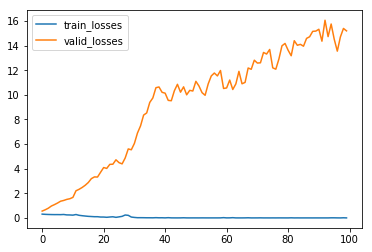

In [31]:
import matplotlib.pyplot as mplot

mplot.plot(train_losses, label='train_losses')
mplot.plot(valid_losses, label='valid_losses')
mplot.legend()
mplot.show()

In [ ]:
# import matplotlib.pyplot as mplot
mplot.plot(train_acc_list, label='train_acc_list')
mplot.plot(valid_acc_list, label='valid_acc_list')
mplot.legend()
mplot.show()